In [1]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [2]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L_arr = [16]
J_arr = [1]
h_arr = [0.05]
lamb_arr = [0.7]
g_arr = [None, 8]

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = 50000

odr = True
flip_threshold = 2

redo_simulations = False

execution_database = "z2_chain_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

# Load hardware results

In [3]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits, odr_compuncomp_circuits
from z2chain.operators import local_pauli_z, local_pauli_x, postselection_operators
from cobos.tokens import ibm_token, group_instance, group_instance2
from utils.postselection import load_postselected_jobs
from utils.hexec import get_backend_best_qubit_chain
from qiskit_ibm_runtime import QiskitRuntimeService
from utils.circs import generate_and_save_circs
from functools import partial
from itertools import product
import os
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_brisbane"
device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

eplg_absolute = 9.08e-3

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

optimization_level = 2

hardware_circuits = [] # hardware_circuits[L][params][t]
if odr: odr_circuits = [] # odr_circuits[L][params][t]
hardware_observable_generating_funcs = [] #hardware_observable_generating_funcs[L][i]
hardware_postselection_operators_funcs = []
extra_options = []

sampler_options = {
    "default_shots": shots,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": shots//100,
        "shots_per_randomization": 100
    }
}

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
    this_circuits = []
    if odr: this_odr_circuits = []
    this_extra_options = []
    for J, h, lamb, g in product(J_arr, h_arr, lamb_arr, g_arr):
        circuits_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
        circs_func_args = (L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
        physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis=x_basis, force_even=True)
        this_circuits.append(physical_circuits)
        this_extra_options.append({"backend": device, "L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": pp_ps, "particle_pair_length": particle_pair_length, "final_time": final_time, "eplg": eplg_absolute})
        if odr:
            odr_func_args = (L, J, h, lamb, final_time, steps, backend, eplg_absolute, g, pp_ps, particle_pair_length, qubits_inds, x_basis)
            this_odr_circuits.append(odr_compuncomp_circuits(*odr_func_args))
    hardware_circuits.append(this_circuits)
    if odr: odr_circuits.append(this_odr_circuits)
    hardware_observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    hardware_postselection_operators_funcs.append(lambda nqubits: postselection_operators((nqubits + 1)//2, x_basis))
    extra_options.append(this_extra_options)

hardware_odr_observables = [] #hardware[L][opts][i]
hardware_raw_samples_dicts = [] #hardware_samples_dicts[L][opts][i][real/cal]
hardware_mitigated_samples_dicts = [] #hardware_postselected_samples_dicts[L][opts][i][real/cal]

for i, L in enumerate(L_arr):
    this_L_observables = []
    this_L_samples_dicts = []
    this_L_postselected_samples_dicts = []  
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        clean_extra_options = extra_options[i][j].copy()
        del clean_extra_options["eplg"]
        if odr:
            this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, clean_extra_options, hardware_circuits[i][j], hardware_postselection_operators_funcs[i], hardware_observable_generating_funcs[i], clean_extra_options, flip_threshold=flip_threshold, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True, odr_circuits=odr_circuits[i][j]) 
        else:
            this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, clean_extra_options, hardware_circuits[i][j], hardware_postselection_operators_funcs[i], hardware_observable_generating_funcs[i], clean_extra_options, flip_threshold=flip_threshold, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True)
        this_L_observables.append(this_observables)
        this_L_samples_dicts.append(this_samples_dicts[1])
        this_L_postselected_samples_dicts.append(this_postselected_samples_dicts[1])
    hardware_odr_observables.append(this_L_observables)
    hardware_raw_samples_dicts.append(this_L_samples_dicts)
    hardware_mitigated_samples_dicts.append(this_L_postselected_samples_dicts)

# Plots

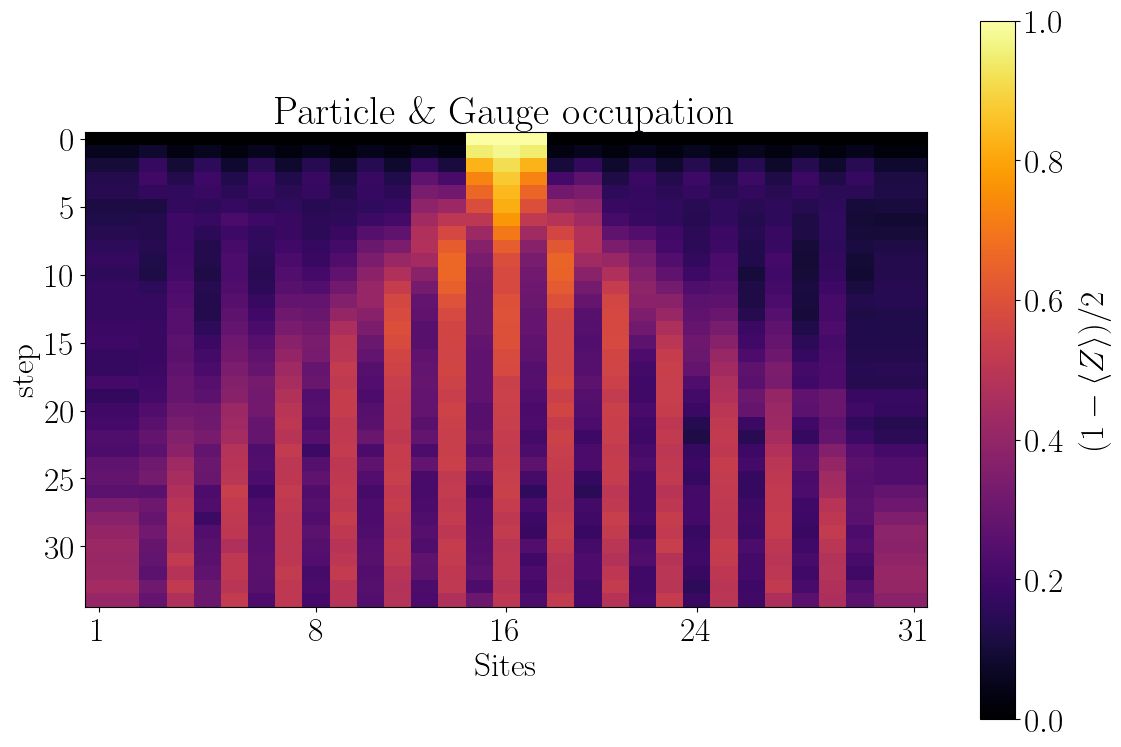

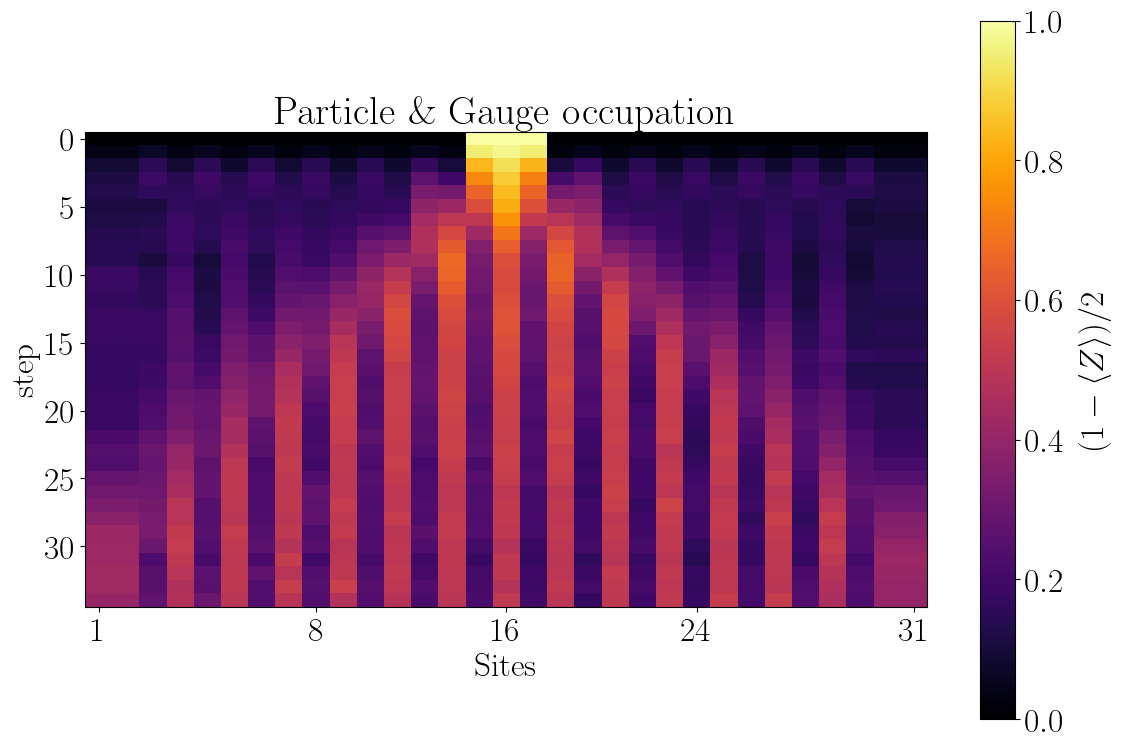

In [14]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        x_t_plot((1 - hardware_odr_observables[i][j][0])/2)

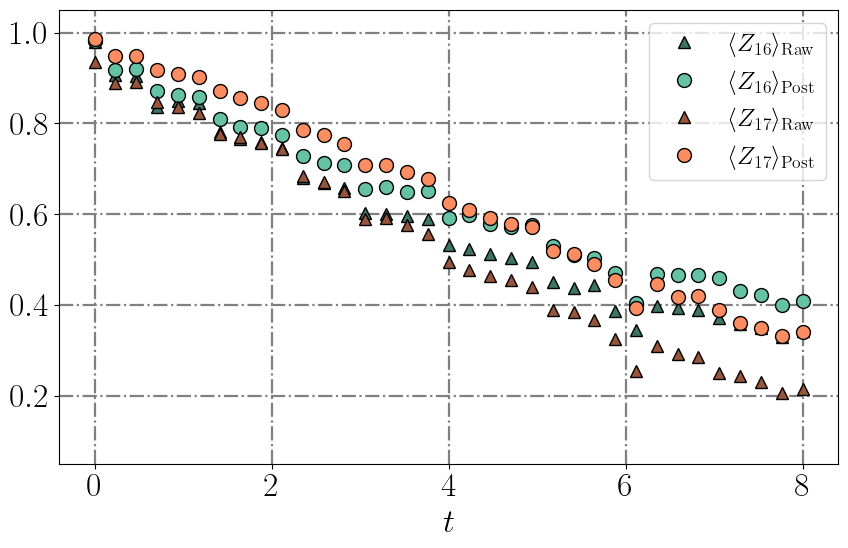

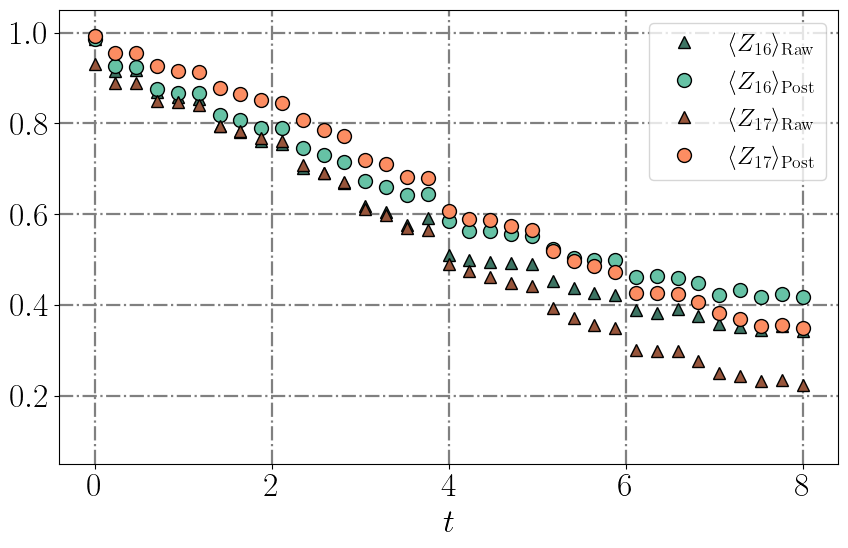

In [5]:
from utils.plotting import observable_depth_mitigation_comparison_plot
from utils.postselection import measure_diagonal_observables
import matplotlib.pyplot as plt
import numpy as np

qubit_indices_plot = [16, 17]
plot_observable_generating_func = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=qbind) for qbind in qubit_indices_plot]
observable_labels = [r"Z_{%d}" % qbind for qbind in qubit_indices_plot]
x_plot = np.linspace(0, final_time, steps)
ylim = [0.05, 1.05]

for i, L in enumerate(L_arr):
    observable_operators = [obsfunc(2*L-1) for obsfunc in plot_observable_generating_func]
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        this_mitigated_observables = np.zeros((len(odr_circuits[i][j]), len(plot_observable_generating_func)))
        this_raw_observables = np.zeros((len(odr_circuits[i][j]), len(plot_observable_generating_func)))
        for k, circ in enumerate(odr_circuits[i][j]):
            this_mitigated_observables[k, :] = measure_diagonal_observables(hardware_mitigated_samples_dicts[i][j][k], observable_operators, circ.layout.final_index_layout())
            this_raw_observables[k, :] = measure_diagonal_observables(hardware_raw_samples_dicts[i][j][k], observable_operators, circ.layout.final_index_layout())
        plot_dict = {(r"Z_{%d}" % qbind): {"Post": this_mitigated_observables[:, k], "Raw": this_raw_observables[:, k]} for k, qbind in enumerate(qubit_indices_plot)}
        observable_depth_mitigation_comparison_plot(plot_dict, x_label=r"$t$", x_plot=x_plot, y_lim=ylim, regression=False, filepath=f"Z_odr_uniform_ft_postselection_effect_{"-".join([str(qb) for qb in qubit_indices_plot])}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")

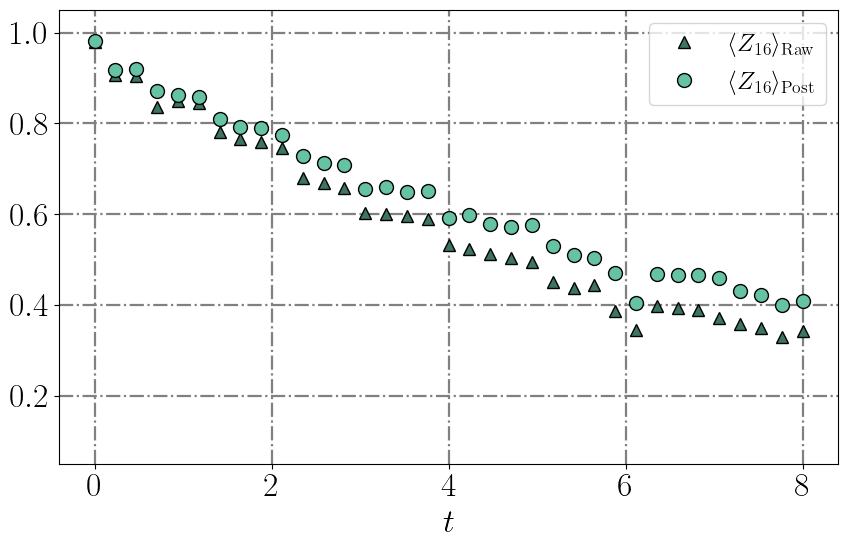

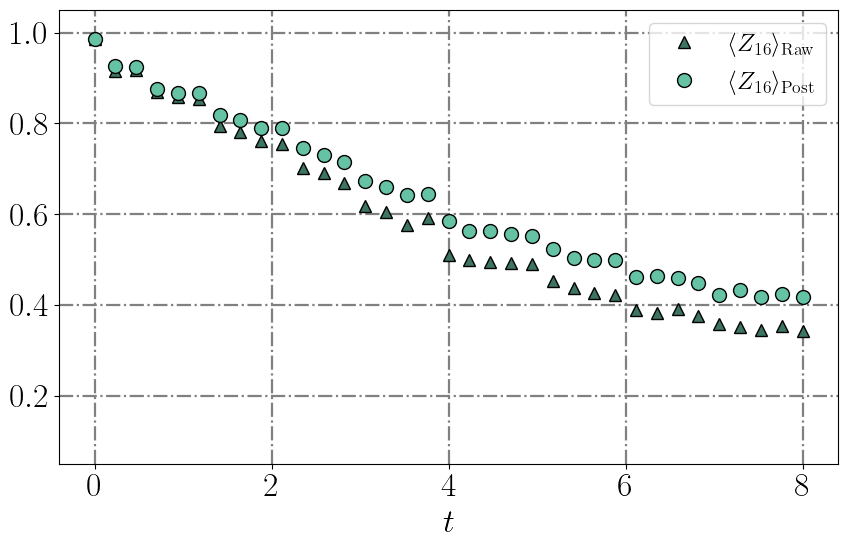

In [6]:
from utils.plotting import observable_depth_mitigation_comparison_plot
import matplotlib.pyplot as plt

qubit_indices_plot = [16]
plot_observable_generating_func = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=qbind) for qbind in qubit_indices_plot]
observable_labels = [r"Z_{%d}" % qbind for qbind in qubit_indices_plot]
x_plot = np.linspace(0, final_time, steps)
ylim = [0.05, 1.05]

for i, L in enumerate(L_arr):
    observable_operators = [obsfunc(2*L-1) for obsfunc in plot_observable_generating_func]
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        this_mitigated_observables = np.zeros((len(odr_circuits[i][j]), len(plot_observable_generating_func)))
        this_raw_observables = np.zeros((len(odr_circuits[i][j]), len(plot_observable_generating_func)))
        for k, circ in enumerate(odr_circuits[i][j]):
            this_mitigated_observables[k, :] = measure_diagonal_observables(hardware_mitigated_samples_dicts[i][j][k], observable_operators, circ.layout.final_index_layout())
            this_raw_observables[k, :] = measure_diagonal_observables(hardware_raw_samples_dicts[i][j][k], observable_operators, circ.layout.final_index_layout())
        plot_dict = {(r"Z_{%d}" % qbind): {"Post": this_mitigated_observables[:, k], "Raw": this_raw_observables[:, k]} for k, qbind in enumerate(qubit_indices_plot)}
        observable_depth_mitigation_comparison_plot(plot_dict, x_label=r"$t$", x_plot=x_plot, y_lim=ylim, regression=False, filepath=f"Z_odr_uniform_ft_postselection_effect_{"-".join([str(qb) for qb in qubit_indices_plot])}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")

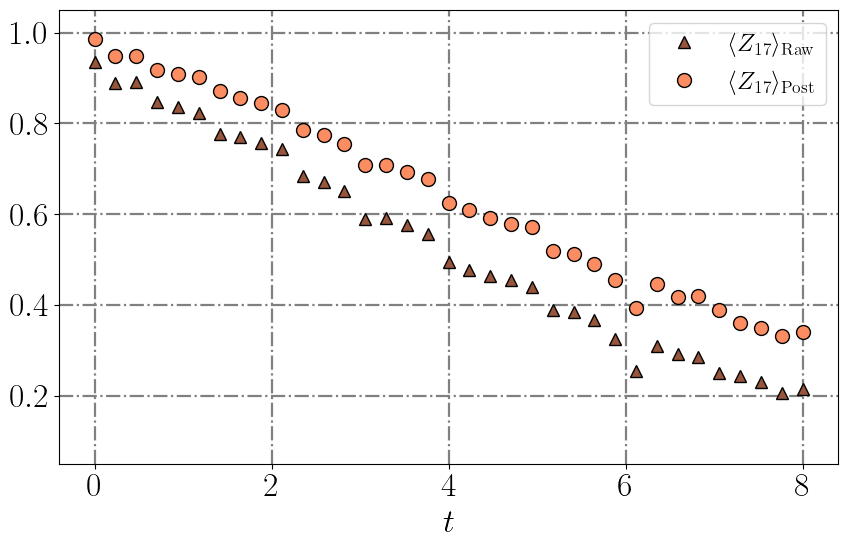

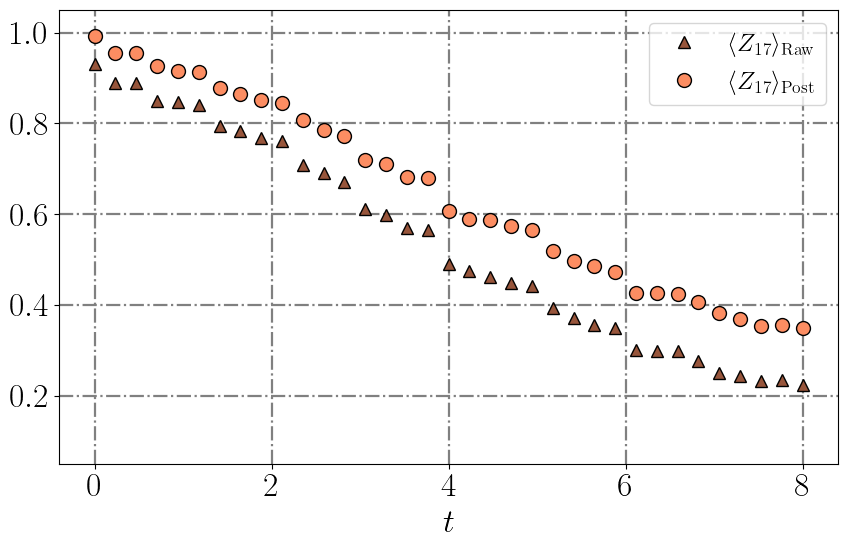

In [7]:
from utils.plotting import observable_depth_mitigation_comparison_plot
import matplotlib.pyplot as plt

qubit_indices_plot = [17]
plot_observable_generating_func = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=qbind) for qbind in qubit_indices_plot]
observable_labels = [r"Z_{%d}" % qbind for qbind in qubit_indices_plot]
x_plot = np.linspace(0, final_time, steps)
ylim = [0.05, 1.05]

colors = [plt.get_cmap("Set2")((1 % 8)/8 + 0.01)]

for i, L in enumerate(L_arr):
    observable_operators = [obsfunc(2*L-1) for obsfunc in plot_observable_generating_func]
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        this_mitigated_observables = np.zeros((len(odr_circuits[i][j]), len(plot_observable_generating_func)))
        this_raw_observables = np.zeros((len(odr_circuits[i][j]), len(plot_observable_generating_func)))
        for k, circ in enumerate(odr_circuits[i][j]):
            this_mitigated_observables[k, :] = measure_diagonal_observables(hardware_mitigated_samples_dicts[i][j][k], observable_operators, circ.layout.final_index_layout())
            this_raw_observables[k, :] = measure_diagonal_observables(hardware_raw_samples_dicts[i][j][k], observable_operators, circ.layout.final_index_layout())
        plot_dict = {(r"Z_{%d}" % qbind): {"Post": this_mitigated_observables[:, k], "Raw": this_raw_observables[:, k]} for k, qbind in enumerate(qubit_indices_plot)}
        observable_depth_mitigation_comparison_plot(plot_dict, x_label=r"$t$", x_plot=x_plot, y_lim=ylim, colors=colors, regression=False, filepath=f"Z_odr_uniform_ft_postselection_effect_{"-".join([str(qb) for qb in qubit_indices_plot])}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")